In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot

### Some observations
* loglik seems to have **inverse correlation** with sigma 2, but no obvious relationship with sigma 1 or sigma 0. sigma 2 has a tendency to increase for the early iterations, then decrease towards zero, so loglik always decreases in the early iterations, then starts to increase rapidly
* A relating observation is in the loglik expression, the terms with expectations in them barely change from iteration to iteration. -log(sigma_2) decreases most dramatically, so overweighing the changes in other terms
* Often, sigma_0 and sigma_2 **decrease to zero** as iterations increase i.e. the model thinks the measurements have no error
* Sometimes, the value of sigma_0 becomes smaller than the resolution of dtype float64 (1e-15) that it becomes zero. Making loglik nan.
* Sometimes, sigmas show small **fluctuations** in higher iterations that leads to the loglik fluctuating
* Often, kalman filter values relating to sigma becomes the same for all t

### Data Generation

In [2]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-.9, -.8], [-.5, -.3]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.6, .4])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = .1
        self.noise_1 = 1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.0, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.binomial(n=1, p=0.0, size=self.num_chronic)#np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        if prob < self.missing and t > 0:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        #np.random.seed(1000)
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            self.plot_trajectory(n)
            self.pct_missing(n)

* Finite difference matches up with gradient --> likelihood function should be correct
    * Is the difference for state noise after one M step too large?
* When given the correct parameters, E step recovers the latent states as shown in the plot
* After M step, gradient wrt the sigmas are exactly zero, which they should be
* Even after a single EM iteration, loglik becomes higher than the loglik with the true params (random seed 1000), because sigma_0 and sigma_2 get arbitrarily small. Why would the model think itself can fit perfectly? (if the model behaves correctly, what's preventing it from setting the variance arbitrarily small to increase likelihood?)

In [3]:
%%capture
model = Model(50, 1, 0.0)
model.run_simulation()

In [39]:
from pykalman import KalmanFilter
X = np.transpose(model.y)
kf = KalmanFilter(transition_matrices = 1, observation_matrices = 1)
kf = kf.em(X, n_iter=5, em_vars='all')

In [43]:
X.shape

(50, 1)

In [40]:
kf.loglikelihood(X)

ValueError: masked arrays are not supported

In [36]:
kf.transition_covariance

array([[0.29059329]])

In [37]:
kf.observation_covariance

array([[0.30967439]])

In [5]:
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False)
em.run_EM(50)

init sigma 0 0.021031316744267253
init sigma 1 0.46094923890465034
init sigma 2 0.027164211357027665
max iterations: 50 reached


In [6]:
em.obs_log_lik()

64.18643061258297

In [7]:
em.finite_diff_output_noise(diff=1e-8)

0.0

In [8]:
em.gradient_output_noise()

0.0

In [9]:
em.finite_diff_state_noise(diff=1e-8)

orig sigma 1 0.8320415340073769
perturbed sigma 1 0.8320415270844458


0.0

In [10]:
em.gradient_state_noise()

0.0

In [11]:
em.sigma_0

0.00039648616625242994

In [12]:
em.sigma_1

0.8320415340073769

In [13]:
em.sigma_2

0.01454359808992642

In [14]:
log_lik_true_param = 63.526059634980015

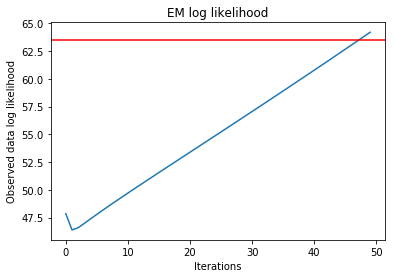

In [15]:
time = [i for i in range(len(em.log_lik))]
plt.plot(time, em.log_lik)
plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

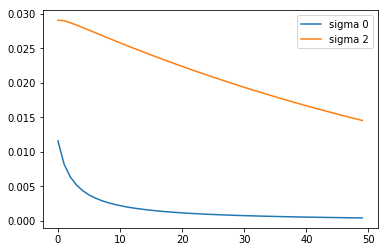

In [16]:
plt.plot(time, em.sigma_0_list, label='sigma 0')
#plt.plot(time, em.sigma_1_list, label='sigma 1')
plt.plot(time, em.sigma_2_list, label='sigma 2')
plt.legend()
plt.show()

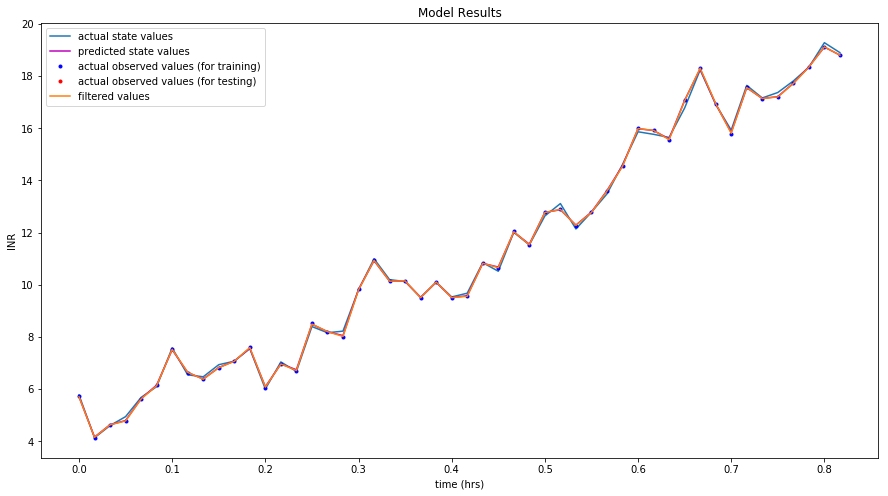

In [17]:
for n in range(model.y.shape[0]):
    plot(em, n, bin_size=1, true_model=True, model=model)

In [18]:
print('estimated A: {}'.format(em.A))
print('true A: {}'.format(model.A))
print('estimated b: {}'.format(em.b))
print('true b: {}'.format(model.b))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated A: [[0. 0.]
 [0. 0.]]
true A: [[-0.9 -0.8]
 [-0.5 -0.3]]
estimated b: [0. 0.]
true b: [0.6 0.4]
estimated initial state mean: 5.708683053712747
true initial state mean: 6
estimated sigma_0: 0.00039648616625242994
true sigma_0: 0.1
estimated sigma_1: 0.8320415340073769
true sigma_1: 1
estimated sigma_2: 0.01454359808992642
true sigma_2: 0.01
estimated ratio: 57.210157270757364
true ratio: 100.0


### Last Observation Carry Forward

In [19]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  

sigma_filter appears to converge to a value for all t > $t_0$. This replicates the updates equations, where y represents sigma_pred, x represents kgain, z represents sigma_filter. Following iterations, z always converges to one of the roots of the polynomial z^2 + a*z -a*b.

In [20]:
a, b = 764, 208
init = 900
x, y, z = [], [], []
z.append(init)
for i in range(10):
    y.append(z[i] + a)
    x.append(y[i] / (y[i] + b))
    z.append((1 - x[i]) * y[i])

below stores the updates for z if we write out the updates equations all in terms of z, z_updates should be the same as z

In [21]:
z_updates = []
z_updates.append(init)
for i in range(10):
    update = b * (z_updates[i] + a) / (z_updates[i] + a + b)
    z_updates.append(update)

In [22]:
z_updates

[900,
 184.88888888888889,
 170.60315021129466,
 170.13558487739206,
 170.1200840138044,
 170.11956990725935,
 170.11955285599996,
 170.1195522904643,
 170.1195522717073,
 170.11955227108518,
 170.11955227106455]

In [23]:
z

[900,
 184.88888888888897,
 170.6031502112947,
 170.1355848773921,
 170.12008401380436,
 170.11956990725938,
 170.11955285599998,
 170.11955229046433,
 170.11955227170728,
 170.11955227108518,
 170.11955227106452]

below generalizes the updates rule for polynomials in the form ax^2 + bx + c. It finds one of the roots if the polynomial has two real roots

In [24]:
x_updates = []
x_updates.append(-100)
p, q, t = 4, -3, -16
for i in range(10):
    update = (-p*t*x_updates[i]-q*t)/(p*q*x_updates[i]+np.square(q)-p*t)
    x_updates.append(update)

In [25]:
x_updates

[-100,
 -5.065200314218382,
 -2.7819265435542113,
 -2.124804216369551,
 -1.8679376485992163,
 -1.7559877103407378,
 -1.7049011915730914,
 -1.6811006799020083,
 -1.6699054007940493,
 -1.6646155987380205,
 -1.6621108338272552]